In [1]:
import mne
import os
import scipy.io
import listen_italian_functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tqdm import tnrange, tqdm_notebook
import seaborn as sns

sns.set(style="darkgrid")
sns.set(font_scale=1.5)

data_path = os.path.dirname(os.getcwd())

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']

# reading the coherence


In [23]:
trial_len = 2
remove_first = 0 #seconds

save_path = data_path + '/data/coherence'

info = mne.io.read_raw_fif((save_path+'-info'),preload=True)
save_path = data_path + '/data/classical_frequency_bands_coherence/coherence-trialLen-'+str(trial_len)+'-removedFirst-'+str(remove_first)+'s'

a=[]
for s in subject_name:
    a.append(pd.read_pickle(save_path+'-'+s))

data = pd.concat((a),axis=0)
data['Delay']=data['Delay'] - 0.5
data['Delay']=data['Delay'].round(decimals=1)

fr = data.Freq.unique()
print(fr)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)

data.sample(10)

Opening raw data file C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info...
This filename (C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
    Range : 40502 ... 1132918 =     40.502 ...  1132.918 secs
Ready.
Reading 0 ... 1092416  =      0.000 ...  1092.416 secs...
['Delta 1 - 3Hz' 'Theta 4 - 7Hz' 'Alpha 8 - 12Hz' 'Beta 13 - 25Hz'
 'Gamma 30 - 40Hz']


Data  \
Feature      Freq            Condition Delay Subject                                                        
TBCD         Gamma 30 - 40Hz Normal     0.2  Martina    [0.05165673304596219, 0.03963654179590943, 0.0...   
TMCD         Gamma 30 - 40Hz Normal     0.2  Manu       [0.05551678905044295, 0.04967496323020792, 0.0...   
TBCD         Beta 13 - 25Hz  All       -0.4  Jonluca    [0.0329469314632945, 0.036264186531033075, 0.0...   
TTCD         Gamma 30 - 40Hz Hyper     -0.5  Manu       [0.05071574630511565, 0.047540784332144384, 0....   
lipaparature Beta 13 - 25Hz  Hypo      -0.2  Gianluca1  [0.053732784964932674, 0.05260214093956014, 0....   
jawaopening  Alpha 8 - 12Hz  Normal     0.1  Alice      [0.06510936638936031, 0.06885369748889172, 0.0...   
lipaparature Beta 13 - 25Hz  Hypo      -0.2  Elenora    [0.07095602390595927, 0.06588054275751203, 0.0...   
             Gamma 30 - 40Hz Hyper      0.5  Marco      [0.055141721253752184, 0.03252806533026309, 0....   
             Alpha 8 - 12Hz  Normal    -0.3  Sara       [0.046827615897846696, 0.04393350716688503, 0....   
                                       -0.4  Martina    [0.05495662606947686, 0.07139414764489876, 0.0...   

                                                        noTrials  Coherence  
Feature      Freq            Condition Delay Subject                         
TBCD         Gamma 30 - 40Hz Normal     0.2  Martina          50   0.050529  
TMCD         Gamma 30 - 40Hz Normal     0.2  Manu             49   0.050983  
TBCD         Beta 13 - 25Hz  All       -0.4  Jonluca         110   0.034546  
TTCD         Gamma 30 - 40Hz Hyper     -0.5  Manu             45   0.045873  
lipaparature Beta 13 - 25Hz  Hypo      -0.2  Gianluca1        26   0.058354  
jawaopening  Alpha 8 - 12Hz  Normal     0.1  Alice            50   0.061699  
lipaparature Beta 13 - 25Hz  Hypo      -0.2  Elenora          25   0.070803  
             Gamma 30 - 40Hz Hyper      0.5  Marco            44   0.051718  
             Alpha 8 - 12Hz  Normal    -0.3  Sara             49   0.041598  
                                       -0.4  Martina          50   0.047028

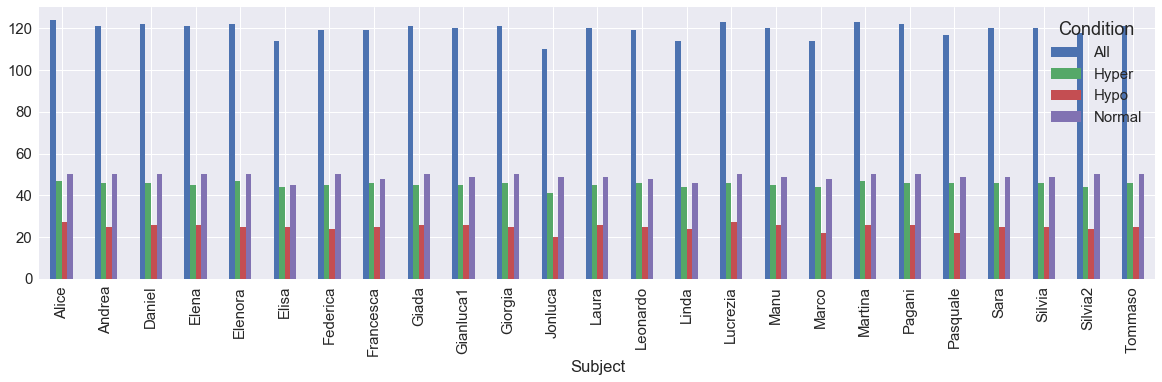

In [24]:
condition = ['Hyper','Normal','Hypo','All']
a=pd.DataFrame(data.loc['envelop',fr[0],condition,0,subject_name])
a=a.groupby(['Subject','Condition']).sum()['noTrials'].unstack().plot(kind='bar',figsize=(20,5),grid=True)

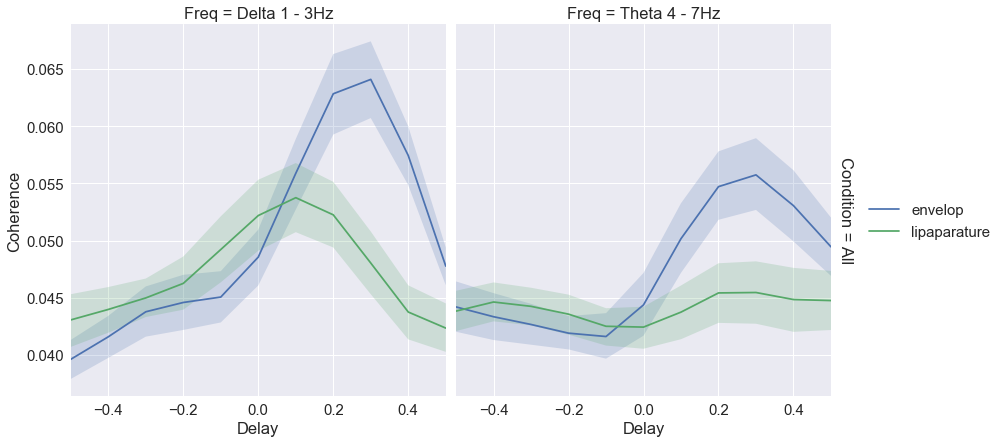

In [11]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop','lipaparature']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10

a = data.loc[extra_channels,freq_band,condition,delay,subject_name]['Coherence']
a = pd.DataFrame(a.reset_index())

g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6)
b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", value="Coherence",color="deep").add_legend()
b = b.set_xlabels('Delay')
b = b.set_ylabels('Coherence')

In [12]:
def get_coherence_value_delay(data,name,subject_name,delay,condition): 
    D = []
    D_std = []
    for d in delay:
        A = []
        B=[]
        for c in condition:
            a  = data.loc[name[0],name[1],c,d,subject_name].as_matrix().mean(axis=0)
            A.append(a[0].mean())
            B.append(a[0].std())

        D.append(A)
        D_std.append(B)
        
    D=np.asarray(D)
    D_std=np.asarray(D_std)
    
    frames=[]
    frames1=[]
    for c in range(0,len(condition)):
        frames.append(pd.DataFrame({condition[c]:D[:,c]}))
        frames1.append(pd.DataFrame({condition[c]:D_std[:,c]}))
        
    df=pd.concat((frames),axis=1)
    df.index = delay
    df.index.name = 'Delay'
    
    df_std=pd.concat((frames1),axis=1)
    df_std.index = delay
    df_std.index.name = 'Delay'
    return df,df_std

def get_coherence_value(data,name,subject_name,d,condition):
    x=[]
    for i in condition:
        a  = data.loc[name[0],name[1],i,d,subject_name].as_matrix().mean(axis=0)
        x.append(a[0])

    return x

def plot_coherence(data,vmax,vmin,axes,name,info): 
    im = mne.viz.plot_topomap(data, info.info, axes=axes, show=False,vmin=vmin,vmax=vmax)
    axes.set(title=name)
    return im

def plot_coherence_preprocess(x,name,condition,delay,info):
    vmax=np.amax(np.concatenate(x, axis=0))
    vmin=np.amin(np.concatenate(x, axis=0))

    fig, axes = plt.subplots(1, len(condition),figsize=(10,4))
    for i in range(0,len(condition)):
        im = plot_coherence(x[i],vmax,vmin,axes[i],condition[i],info)

    fig.suptitle(name[0]+'-Delay-'+ str(delay)+ '-'+name[1])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.04, 0.3])
    fig.colorbar(im[0], cax=cbar_ax)
    fig.show()
    
def plot_coherence_preprocess_delay(x,name,condition,delay,info):
    vmax=np.amax(np.concatenate(x, axis=0))
    vmin=np.amin(np.concatenate(x, axis=0))

    fig, axes = plt.subplots(1, len(delay),figsize=(20,6))
    for i in range(0,len(delay)):
        im = plot_coherence(x[i][0],vmax,vmin,axes[i],delay[i],info)

    fig.suptitle(name[0]+ ' - '+name[1]+' - '+ str(condition[0]),y=0.7)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.50, 0.01, 0.15])
    fig.colorbar(im[0], cax=cbar_ax)
    #fig.show()
    return fig
    

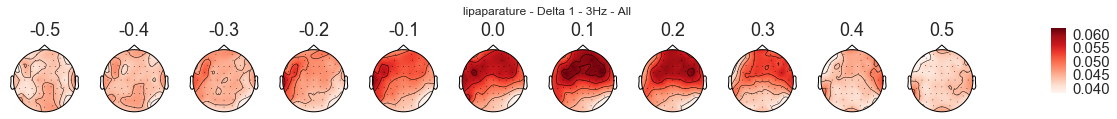

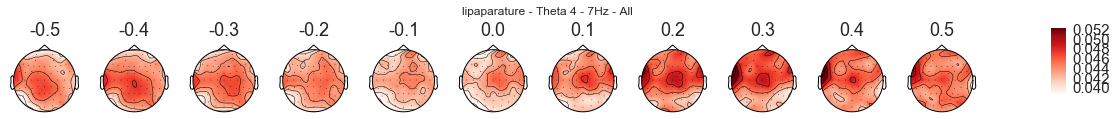

In [14]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

#freq_band = ['fr 3 - 5Hz']
extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['lipaparature']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']
delay = np.arange(-5,6) / 10



for f in freq_band:
    A = []
    for feat in extra_channels:
        name = (feat,f)
        for d in delay:
            a = get_coherence_value(data,name,subject_name,d,condition)
            A.append(a)
    a = plot_coherence_preprocess_delay(A,name,condition,delay,info)
    


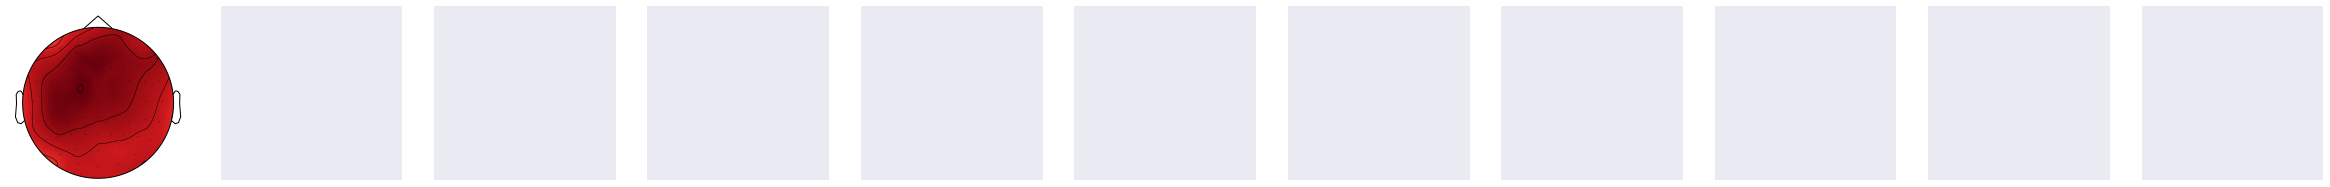

ValueError: Axes instance argument was not found in a figure.

In [75]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']
freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
 'fr 9 - 11Hz', 'fr 10 - 12Hz']
freq_band = ['fr 3 - 5Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']
delay = np.arange(-5,6) / 10


freq_band = ['fr 1 - 3Hz']
a = data.loc[extra_channels,freq_band,condition,delay,subject_name]['Data']
a = pd.DataFrame(a.reset_index())
a.sample(5)

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].mean()
    #print(kwargs)
    #d = data.pivot(columns=args[0]).as_matrix().mean(axis=0)
    #sns.heatmap(d, **kwargs)
    mne.viz.plot_topomap(x, info.info)

fg = sns.FacetGrid(a, col='Delay', row = 'Freq', margin_titles=True)
fg.map_dataframe(draw_heatmap, 'Data')


# Measure the coherence in specific delay and shifting the eeg and speech from speech onset

Opening raw data file C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info...
This filename (C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
    Range : 40502 ... 1132918 =     40.502 ...  1132.918 secs
Ready.
Reading 0 ... 1092416  =      0.000 ...  1092.416 secs...


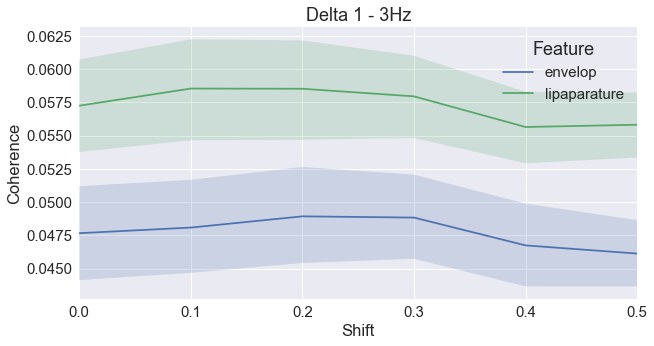

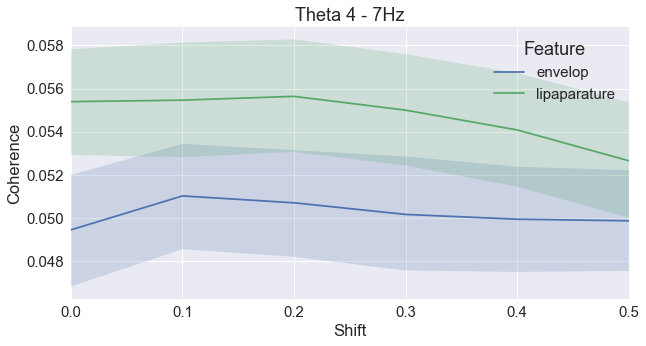

In [171]:
trial_len = 2
remove_first = [0,0.1,0.2,0.3,0.4,0.5] #seconds
delay = [0]

freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop','lipaparature']

condition = ['Hyper','Normal','Hypo','All']
condition = ['Normal']

save_path = data_path + '/data/coherence'
info = mne.io.read_raw_fif((save_path+'-info'),preload=True)
frame = []
for rf in remove_first:
    save_path = data_path + '/data/shift/coherence-trialLen-'+str(trial_len)+'-removedFirst-'+str(rf)+'s'
    a=[]
    for s in subject_name:
        a.append(pd.read_pickle(save_path+'-'+s))

    data = pd.concat((a),axis=0)
    #data['Delay']=data['Delay']
    data['Delay']=data['Delay'] - 0.5

    data['Delay']=data['Delay'].round(decimals=1)
    data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
    data.sort_index(inplace=True)
    a  = data['Data'].apply(lambda x: np.mean(x))
    data['Coherence'] = pd.Series(a, index=data.index)

    # plot coherence values according to time shift (remove_first)    

    AA = []
    for f in freq_band:
        a = data.loc[extra_channels,f,condition,delay,subject_name]['Coherence']
        a = data.loc[extra_channels,f,condition]['Coherence']
        a = pd.DataFrame(a.reset_index())
        a['Shift'] = rf
        AA.append(a)
        
    data=pd.concat((AA),axis=0)
    frame.append(data)
    
data=pd.concat((frame),axis=0)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)
data.sample(10)

for f in freq_band:
    #a = data.loc[extra_channels,f,condition,delay,subject_name]['Coherence']
    a = data.loc[extra_channels,f,condition,delay]
    a = pd.DataFrame(a.reset_index())
    
    fig, axes = plt.subplots(1, 1,figsize=(10,5))
    # Plot the response with standard error
    b=sns.tsplot(data=a, time="Shift", unit="Subject",condition="Feature", value="Coherence",ax=axes)
    b=b.set_title(f)

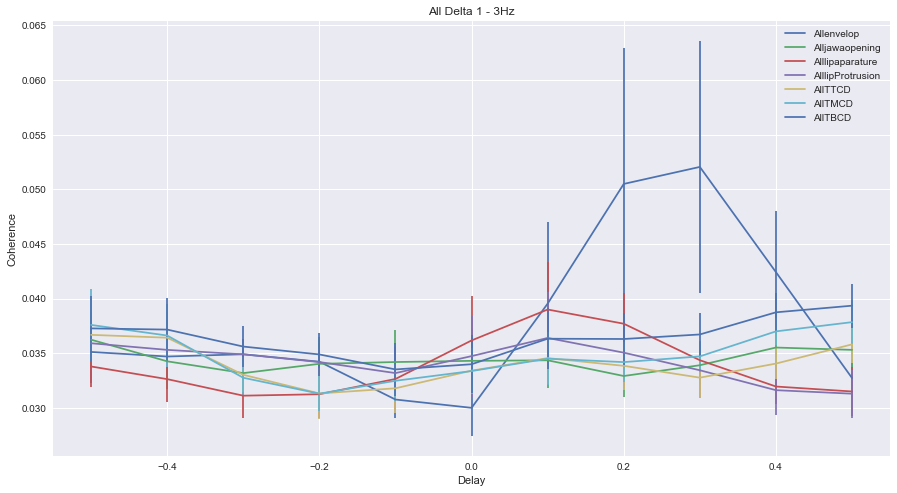

In [155]:
freq_band = ('Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz')
freq_band = ['Delta 1 - 3Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
#extra_channels = ['lipaparature','jawaopening']

condition = ['Hyper','Normal','Hypo']
condition = ['All']

for f in freq_band:
    
    frames=[]
    frames_std=[]
    for feat in extra_channels:
        name = (feat,f)
        delay = np.arange(-5,6) / 10
        a,b = get_coherence_value_delay(data,name,subject_name,delay,condition)
        
        for c in condition:
            frames.append(pd.DataFrame({c+feat:a[c]}))
            frames_std.append(pd.DataFrame({c+feat:b[c]}))
            
    df=pd.concat((frames),axis=1)
    df_std=pd.concat((frames_std),axis=1)

    if(len(condition)!=1):
        fig, axes = plt.subplots(1, len(condition),figsize=(15,5))
    
    for c in range(0,len(condition)):
        a = df[[condition[c]+s for s in extra_channels]]
        b = df_std[[condition[c]+s for s in extra_channels]]

        if(len(condition)==1):
            ax = a.plot(grid=True,title=condition[c]+' '+name[1],figsize=(15,8))
        else:
            ax = a.plot(grid=True,title=condition[c]+' '+name[1],ax=axes[c])
        ax.set_ylabel('Coherence')
        #ax.fill_between(a.index, ma-2*mstd, ma+2*mstd, color='b', alpha=0.2)

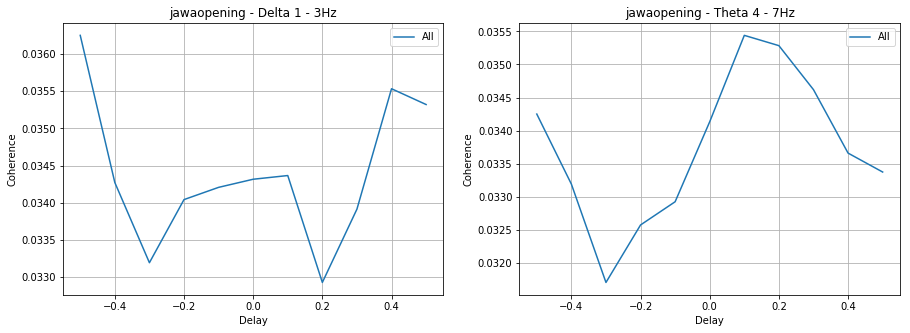

In [45]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['jawaopening']

condition = ['Hyper','Normal','Hypo']
condition = ['All']

for feat in extra_channels:
    fig, axes = plt.subplots(1, 2,figsize=(15,5))
    for f in range(0,len(freq_band)):
        name = (feat,freq_band[f])
        delay = np.arange(-5,6) / 10
        a = get_coherence_value_delay(data,name,subject_name,delay,condition)
        ax=a.plot(grid=True,ax=axes[f],title=name[0]+' - '+name[1])
        ax= ax.set_ylabel('Coherence')

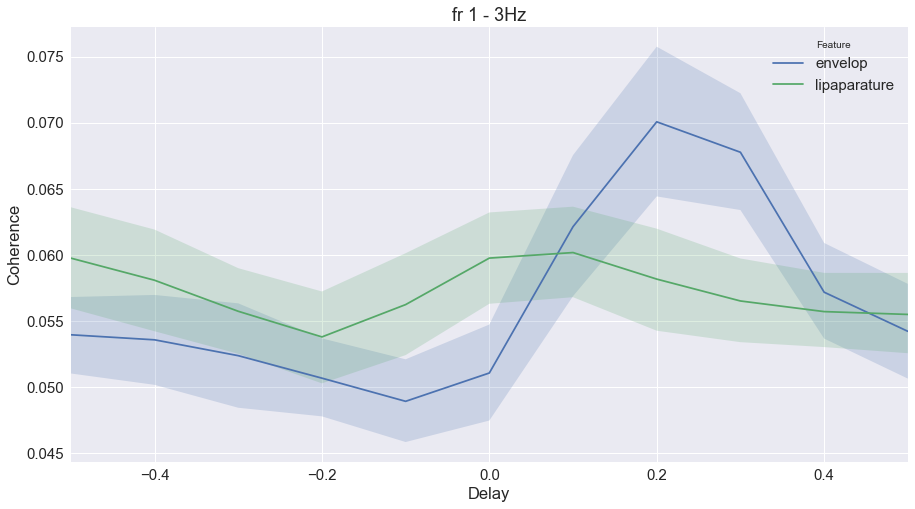

In [80]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz']
freq_band = ['fr 1 - 3Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop','lipaparature']

condition = ['Hyper','Normal','Hypo','All']
condition = ['Hyper']

delay = np.arange(-5,6) / 10

for f in freq_band:
    a = data.loc[extra_channels,f,condition,delay,subject_name]['Coherence']
    a = pd.DataFrame(a.reset_index())

    fig, axes = plt.subplots(1, 1,figsize=(15,8))
    # Plot the response with standard error
    b=sns.tsplot(data=a, time="Delay", unit="Subject",condition="Feature", value="Coherence",ax=axes)
    b=b.set_title(f)


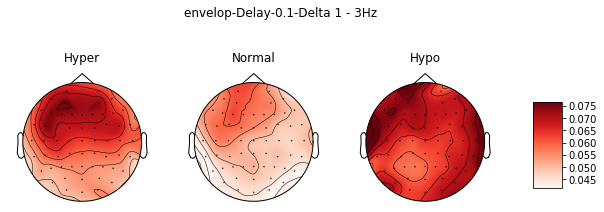

In [7]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop']

condition = ['Hyper','Normal','Hypo']

for f in freq_band:
    for feat in extra_channels:
        name = (feat,f)
        delay = 0.1
        a = get_coherence_value(data,name,subject_name,delay,condition)
        plot_coherence_preprocess(a,name,condition,delay,info)

In [22]:
Hyper  = data.loc['envelop','Theta 4 - 7Hz','Hyper',0.3,subject_name]
Hyper['Data'].mean()

array([0.05560687, 0.05507446, 0.05548149, 0.05541937, 0.05857331,
       0.0540149 , 0.05473118, 0.05608336, 0.0587574 , 0.05749764,
       0.05543292, 0.0574329 , 0.05992582, 0.06059325, 0.05674436,
       0.05743519, 0.06013957, 0.05820117, 0.05975465, 0.05950889,
       0.05739149, 0.05793776, 0.05878256, 0.06010314, 0.05935551,
       0.05600672, 0.05563843, 0.05679031, 0.05539965, 0.052913  ,
       0.05482032, 0.0542517 , 0.05300193, 0.05514823, 0.05740111,
       0.05615587, 0.05225823, 0.05468318, 0.05693435, 0.05426684,
       0.05815539, 0.05759441, 0.06132453, 0.05835428, 0.05761042,
       0.05736507, 0.05847064, 0.06079013, 0.0590886 , 0.05784651,
       0.05636291, 0.05847842, 0.05971438, 0.05977433, 0.05479094,
       0.05686286, 0.06022844, 0.05955223, 0.05559246])